In [8]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, LSTM, Flatten, Conv2D, MaxPooling2D

# base_model = ResNet50(weights='imagenet', include_top=False)


In [9]:
model = Sequential([
    
    Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    
    Conv2D(64,(3,3),activation='relu',input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    
    Conv2D(128,(3,3),activation='relu',input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    
    Conv2D(256,(3,3),activation='relu',input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dropout(0.5),
    Dense(512,activation='relu'),
    # Dense(117,activation='softmax')
    Dense(2,activation='softmax')
])

# Should add metric=[...]
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 17, 17, 128)      

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_dir = r'..\Data\labledCountries\train'
validation_data_dir = r'..\Data\labledCountries\val'

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

In [12]:

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical',
    # shuffle=True
    )

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical')


Found 8018 images belonging to 2 classes.
Found 952 images belonging to 2 classes.


In [13]:
import numpy as np

class_counts = np.bincount(train_generator.classes) ** 0.01

# class_probabilities = class_counts
class_probabilities = class_counts / np.bincount(train_generator.classes)
class_probabilities = np.where(np.isinf(class_probabilities) | np.isnan(class_probabilities), 0, class_probabilities)
# class_probabilities[44] = 0
class_probabilities = class_probabilities / np.sum(class_probabilities)
class_weights = {i: weight for i, weight in enumerate(class_probabilities)}

class_indices = train_generator.class_indices

class_probabilities_dict = {class_name: class_probabilities[idx] for class_name, idx in class_indices.items()}

sorted_class_probabilities = sorted(class_probabilities_dict.items(), key=lambda item: item[1], reverse=False)

for class_name, probability in sorted_class_probabilities:
    print(f'{class_name}: {probability}')


Denmark: 0.49148040231529333
Portugal: 0.5085195976847067


In [14]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history = model.fit(
    train_generator,
    # steps_per_epoch=2000,
    validation_data=validation_generator,
    # validation_steps=200,
    batch_size=64,
    epochs=3,
    # class_weight = class_weights,
    # verbose=1
    callbacks=[early_stopping]
)

Epoch 1/3
126/126 [==============================] - 181s 1s/step - loss: 0.5905 - categorical_accuracy: 0.6936 - val_loss: 0.5363 - val_categorical_accuracy: 0.7426
Epoch 2/3
126/126 [==============================] - 68s 538ms/step - loss: 0.4517 - categorical_accuracy: 0.7932 - val_loss: 0.4738 - val_categorical_accuracy: 0.7742
Epoch 3/3
126/126 [==============================] - 87s 692ms/step - loss: 0.4290 - categorical_accuracy: 0.8078 - val_loss: 0.4666 - val_categorical_accuracy: 0.7668


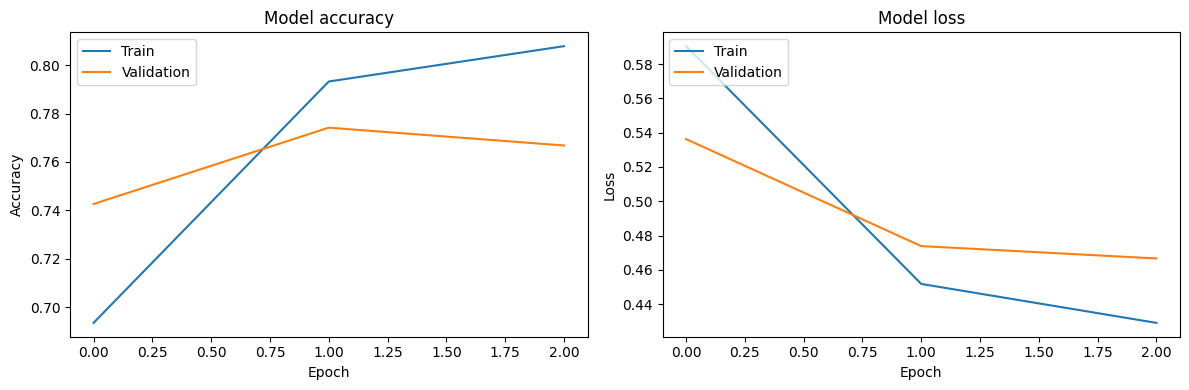

In [15]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'])  
plt.plot(history.history['val_categorical_accuracy']) 
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [16]:
model.save('my_model.h5')


c:\Users\21thebes\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)

data_dir = r'..\Data\labledCountries\test'
test_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle = False
)

class_names = test_generator.class_indices.keys()

Found 1038 images belonging to 2 classes.


33/33 [==============================] - 18s 559ms/step
Classification Report: 
              precision    recall  f1-score   support

     Denmark       0.67      0.84      0.74       431
    Portugal       0.86      0.70      0.77       607

    accuracy                           0.76      1038
   macro avg       0.76      0.77      0.76      1038
weighted avg       0.78      0.76      0.76      1038



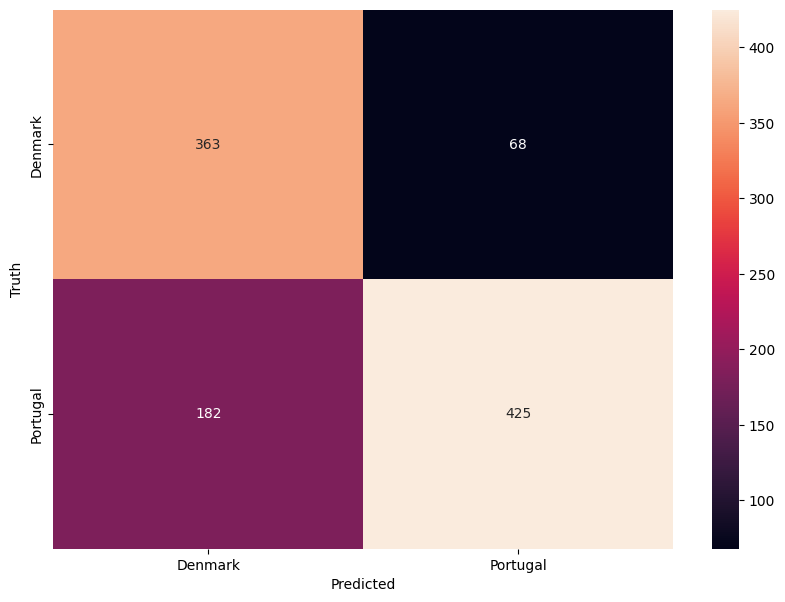

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

y_true = test_generator.classes

# Predict the values from the validation dataset
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 

# Visualize the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(confusion_mtx, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Truth')

# classification report
print('Classification Report: ')
print(classification_report(y_true, y_pred_classes, target_names=class_names))


In [19]:
import tensorflow as tf
import cv2
import random


num_batches = len(test_generator)
batch_num = random.randint(0, num_batches - 1)

# Get the images and labels for this batch
images, labels = test_generator[batch_num]

# Randomly select an image and label from the batch
num_images = len(images)
image_num = random.randint(0, num_images - 1)

image = images[image_num]
label = labels[image_num]

# Create a model that maps the input image to the last convolutional layer
model_layers = [layer.output for layer in model.layers]
activation_model = tf.keras.models.Model(inputs=model.input, outputs=model_layers)

# Get the activations from the last convolutional layer
activations = activation_model.predict(image.reshape(1, *image.shape))

# Get the last convolutional layer
last_conv_layer = model.get_layer(index=-6)

# Create a new model that outputs both the original model's predictions 
# as well as the output of the last convolutional layer
new_model = tf.keras.models.Model(
    inputs=model.inputs, 
    outputs=[model.output, last_conv_layer.output]
)

with tf.GradientTape() as tape:
    # Forward pass
    preds, conv_outputs = new_model(tf.expand_dims(image, axis=0))
    # Get the class index
    class_idx = tf.argmax(preds[0])
    # Calculate the loss value for the class index
    loss = preds[:, class_idx]

# Get the gradients of the loss with respect to the convolutional layer's output
grads = tape.gradient(loss, conv_outputs)

# Pool gradients over all axes leaving out the channel dimension
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# Multiply the convolutional layer's output with the pooled gradients across all channels
# And average it across all channels to obtain the heatmap
heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

# Normalize the heatmap between 0 & 1 for visualization
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

# Convert the heatmap to numpy array before resizing
heatmap_np = heatmap[0].numpy()

# Resize the heatmap to match the size of the original image
heatmap_resized = cv2.resize(heatmap_np, (image.shape[1], image.shape[0]))

class_names = list(test_generator.class_indices.keys())

# Get the model's prediction
preds = model.predict(tf.expand_dims(image, axis=0))
predicted_class_idx = tf.argmax(preds[0]).numpy()

# Get the predicted class name
predicted_class_name = class_names[predicted_class_idx]

# Get the correct class name
correct_class_idx = tf.argmax(label).numpy()
correct_class_name = class_names[correct_class_idx]

# Plot the original image and the heatmap
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title(f'True: {correct_class_name}\nPredicted: {predicted_class_name}\n\nOriginal Image')

plt.subplot(1, 2, 2)
plt.imshow(heatmap_resized)
plt.title('Heatmap')
plt.show()



FileNotFoundError: [Errno 2] No such file or directory: '..\\Data\\labledCountries\\test\\Poland\\_t3q0ct2UHEnJ0t3jR2SkQNum0.jpg'

In [ ]:
import tensorflow as tf
print(tf.__version__)

import tensorflow as tf
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print('No GPU found')



2.15.0
No GPU found
